where does student fail? is it the harder or easier sequences? uncertainty?
- is it the harder or easier sequences? (as indicated by the teacher uncertainty)
- to this end, we can use the teacher uncertainty as a proxy for the difficulty of the sequence, and inspect teacher uncertainty for the sequences where the student fails

In [1]:
import os
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load the dataset
df_test = pd.read_csv('../data/robustness_study/preprocessed/test.csv', sep='\t', index_col=0)
df_test.head()

,text,target
0,in class still drunk from last night and this ...,1
1,sighs of relief from beijing guoan fans <hasht...,0
2,<user> <user> <user> they do why else do teach...,1
3,preparing to be called a nigger all night i me...,1
4,rt <user> we dont love these hoes <url>,1


In [4]:
# load the predictions - focus on MC dropout
# teacher predictions
with open('../out/bert_teacher/final_hd020_ad030_cd020/results/results.json', 'r') as f:
    teacher_mcd_results = json.load(f)
    
# student predictions
with open('../out/bert_student/m5_k10/e2/results/results.json', 'r') as f:
    student_mcd_results = json.load(f)

In [6]:
teacher_mcd_predictions = pd.DataFrame({'y_true': teacher_mcd_results['y_true'],
                                        'y_pred': teacher_mcd_results['y_pred'],
                                        'y_prob': teacher_mcd_results['y_prob'],
                                        'bald_score': teacher_mcd_results['bald_score'],
                                       },
                                       index=df_test.index)

teacher_mcd_predictions.head()

,y_true,y_pred,y_prob,bald_score
0,1,1,0.998835,6.274786e-08
1,0,0,0.015718,1.977161e-04
2,1,1,0.998872,4.237518e-08
3,1,1,0.998842,4.470348e-08
4,1,1,0.998899,5.366746e-08


In [7]:
student_mcd_predictions = pd.DataFrame({'y_true': student_mcd_results['y_true'],
                                        'y_pred': student_mcd_results['y_pred'],
                                        'y_prob': student_mcd_results['y_prob'],
                                        'bald_score': student_mcd_results['bald_score'],
                                       },
                                       index=df_test.index)

student_mcd_predictions.head()

,y_true,y_pred,y_prob,bald_score
0,1,1,0.998972,0.000007
1,0,0,0.011629,0.035872
2,1,1,0.999027,0.000002
3,1,1,0.998862,0.000009
4,1,1,0.999005,0.000004


In [8]:
# get all sequences that teacher gets right and student gets wrong
# teacher gets right
teacher_correct = teacher_mcd_predictions[teacher_mcd_predictions['y_true'] == teacher_mcd_predictions['y_pred']]
# student gets wrong
student_wrong = student_mcd_predictions[student_mcd_predictions['y_true'] != student_mcd_predictions['y_pred']]

In [10]:
# get the sequences where the teacher gets right and the student gets wrong
teacher_correct_student_wrong = teacher_correct[teacher_correct.index.isin(student_wrong.index)]

In [11]:
teacher_correct_student_wrong

,y_true,y_pred,y_prob,bald_score
68,0,0,0.488641,0.001451
135,0,0,0.368691,0.002035
471,1,1,0.559307,0.001240
518,0,0,0.463860,0.001741
941,0,0,0.212170,0.001622
1206,0,0,0.172989,0.001387
1669,0,0,0.315525,0.001297
1911,0,0,0.268331,0.002172
1929,0,0,0.497736,0.001507
2077,1,1,0.529206,0.001589


In [12]:
# subset corresponding student predictions
student_wrong_teacher_correct = student_wrong.loc[teacher_correct_student_wrong.index]

In [13]:
student_wrong_teacher_correct

,y_true,y_pred,y_prob,bald_score
68,0,1,0.574930,0.049890
135,0,1,0.594946,0.054184
471,1,0,0.073583,0.064164
518,0,1,0.551004,0.067020
941,0,1,0.972752,0.003407
1206,0,1,0.775340,0.030223
1669,0,1,0.657361,0.073200
1911,0,1,0.823263,0.029335
1929,0,1,0.506555,0.050085
2077,1,0,0.232624,0.077314


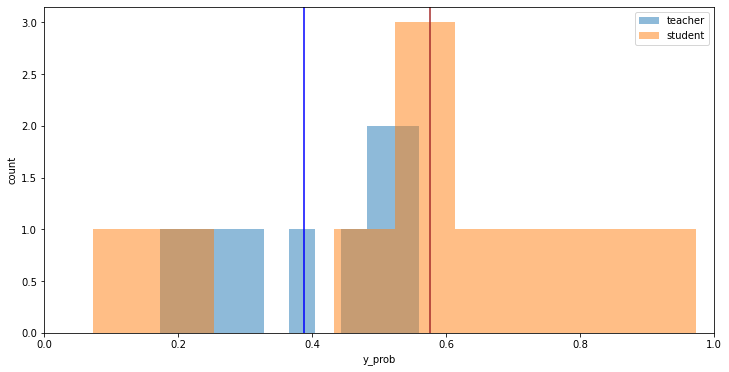

In [16]:
# plot teacher y_prob for the sequences where the teacher gets right and the student gets wrong along with mean
plt.figure(figsize=(12, 6))
plt.hist(teacher_correct_student_wrong['y_prob'], bins=10, alpha=0.5, label='teacher')
plt.axvline(teacher_correct_student_wrong['y_prob'].mean(), color='blue')
plt.hist(student_wrong_teacher_correct['y_prob'], bins=10, alpha=0.5, label='student')
plt.axvline(student_wrong_teacher_correct['y_prob'].mean(), color='brown')
plt.xlabel('y_prob')
plt.ylabel('count')
plt.xlim(0, 1)
plt.legend();

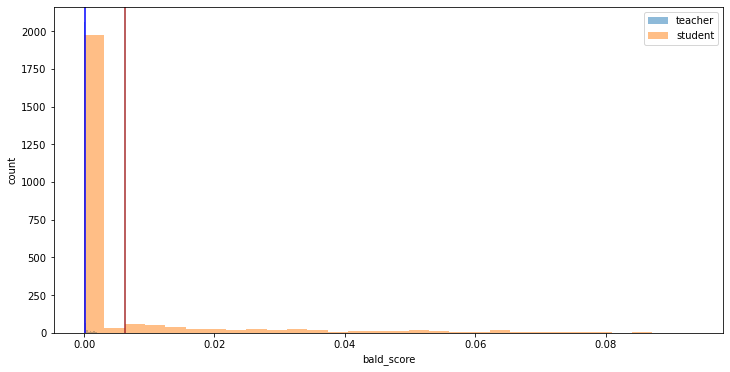

In [33]:
# bald score - overall tea cher vs student and for the sequences where the teacher gets right and the student gets wrong
plt.figure(figsize=(12, 6))
plt.hist(teacher_mcd_predictions['bald_score'], bins=30, alpha=0.5, label='teacher')
plt.axvline(teacher_mcd_predictions['bald_score'].mean(), color='blue')
plt.hist(student_mcd_predictions['bald_score'], bins=30, alpha=0.5, label='student')
plt.axvline(student_mcd_predictions['bald_score'].mean(), color='brown')
plt.xlabel('bald_score')
plt.ylabel('count')
plt.legend();

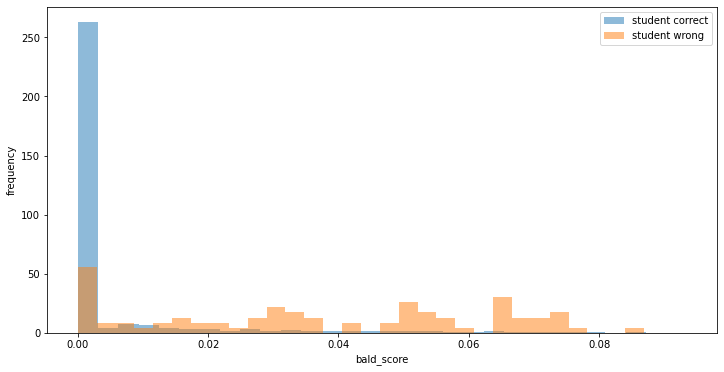

In [25]:
# student bald score distribution for sequences that are wrong vs right
plt.figure(figsize=(12, 6))
plt.hist(student_mcd_predictions[student_mcd_predictions['y_true'] == student_mcd_predictions['y_pred']]['bald_score'], bins=30, alpha=0.5, label='student correct', density=True)    
plt.hist(student_mcd_predictions[student_mcd_predictions['y_true'] != student_mcd_predictions['y_pred']]['bald_score'], bins=30, alpha=0.5, label='student wrong', density=True)
plt.xlabel('bald_score')
plt.ylabel('frequency')
plt.legend();

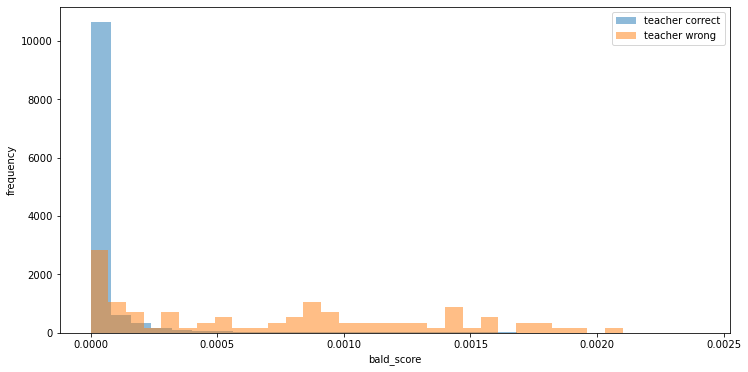

In [26]:
# teacher bald score distribution for sequences that are wrong vs right
plt.figure(figsize=(12, 6))
plt.hist(teacher_mcd_predictions[teacher_mcd_predictions['y_true'] == teacher_mcd_predictions['y_pred']]['bald_score'], bins=30, alpha=0.5, label='teacher correct', density=True)  
plt.hist(teacher_mcd_predictions[teacher_mcd_predictions['y_true'] != teacher_mcd_predictions['y_pred']]['bald_score'], bins=30, alpha=0.5, label='teacher wrong', density=True)
plt.xlabel('bald_score')
plt.ylabel('frequency')
plt.legend();

In [ ]:
# TODO: are teacher bald scores computed correctly? -> yes, they are, just need to be interpreted in relative terms (i.e. relative to the teacher)